In [174]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import spearmanr as scor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.metrics import auc as AUC

sns.set_style('whitegrid')
%matplotlib inline

## Confunding role of cell death signature in mechanism of action discovery
Perturbation gene expression signatures can be used to identify meachinsom of action (MoA) of unknown compounds (based on singature similarity). As cell death / proliferation has an important effect on gene expression sigantures, we hypothesised that cell death / proliferation can infer with MoA identification.

To test this hypothesis, we analysed the similarity between signature pairs (using Spearman correlation). We analysed the similarities between unrelated, toxic and shared MoA pairs.

In [2]:
def remove_space(s):
    """just some helper function to clean CTRP metadata
    removes space from end/start of string s"""
    while (s[0]==' ') or (s[-1]==' '):
        if s[0]==' ':
            s=s[1:]
        if s[-1]==' ':
            s=s[:-1]
    return s

In [3]:
#CTRP metadata desribes target of CTRP drugs
moa=pd.read_table('../data/CTRP/v20.meta.per_compound.txt',
                 sep='\t',header=0,index_col=[2])
#get targets and activities for these drugs
activities=[]
targets=[]
for cpd in moa.index:
    trg=str(moa.loc[cpd,'gene_symbol_of_protein_target']).split(';')
    targets+=trg
    act=str(moa.loc[cpd,'target_or_activity_of_compound']).split(';')
    act_new=[]
    for a in act:
        act_new.append(remove_space(a))
    act=act_new
    activities+=act
activities=list(set(activities))
targets=list(set(targets))
#create a matrix to store these targets and activities for compounds
activity_matrix=pd.DataFrame(0,index=moa.index,columns=activities)
target_matrix=pd.DataFrame(0,index=moa.index,columns=targets)
for cpd in moa.index:
    trg=str(moa.loc[cpd,'gene_symbol_of_protein_target']).split(';')
    act=str(moa.loc[cpd,'target_or_activity_of_compound']).split(';')
    act_new=[]
    for a in act:
        act_new.append(remove_space(a))
    act=act_new
    activity_matrix.loc[cpd,act]=1
    target_matrix.loc[cpd,trg]=1
# remove meaningless activities and targets
del target_matrix['nan']
del activity_matrix['product of diversity oriented synthesis']
del activity_matrix['screening hit']
del activity_matrix['natural product']

In [4]:
#shared_moa matrix creation
#rows/columns are pert_ids, value is 1 if moa is shared, 0 if not
shared_moa=pd.DataFrame(np.identity(len(moa),int),index=moa.index,columns=moa.index)
for cpd in moa.index:
    acts=activity_matrix.columns[activity_matrix.loc[cpd]==1]
    sim_act=activity_matrix.index[np.sum(activity_matrix[acts],1)>0]
    shared_moa.loc[cpd,sim_act]=1
    trgs=target_matrix.columns[target_matrix.loc[cpd]==1]
    sim_trg=target_matrix.index[np.sum(target_matrix[trgs],1)>0]
    shared_moa.loc[cpd,sim_trg]=1
shared_moa.to_csv('../results/moa/shared_moa_ctrp.csv',sep=',')

Now we know which CTRP drugs have shared MoA. Next we calulate the similarities between CTRP-L1000 signatures.

In [5]:
sig_info=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                      sep=',',header=0,index_col=[0])
signatures=pd.read_table('../results/CTRP/signatures_merged_lm.csv',
                        sep=',',header=0,index_col=[0])
fil=sig_info['pert_itime']=='24 h'
sig_info=sig_info[fil]
signatures=signatures.loc[sig_info.index]
similarity=pd.DataFrame(scor(signatures.T)[0],index=signatures.index,
                        columns=signatures.index)

Now we can create different masks to get: shared moa signatures / shared cell line signatures / toxic signatures / non toxic signautes.

In [9]:
#moa mask
moa_mask=pd.DataFrame(False,index=similarity.index,
                     columns=similarity.columns)
for cpd in shared_moa.index:
    sig_ids=sig_info.index[sig_info['pert_id']==cpd]
    similar_cpds=shared_moa.columns[shared_moa.loc[cpd]==1]
    similar_ids=sig_info.index[np.in1d(sig_info['pert_id'],similar_cpds)]
    moa_mask.loc[sig_ids,similar_ids]=True

In [10]:
#cell line mask
cell_mask=pd.DataFrame(False,index=similarity.index,
                      columns=similarity.columns)
for cell in list(set(sig_info['cell_id'])):
    sig_ids=sig_info.index[sig_info['cell_id']==cell]
    cell_mask.loc[sig_ids,sig_ids]=True

In [13]:
#non toxic mask
non_tox_mask=pd.DataFrame(False,index=similarity.index,
                         columns=similarity.columns)
sig_ids=sig_info.index[sig_info['cpd_avg_pv']>0.8] # threshold for non toxicity
non_tox_mask.loc[sig_ids,sig_ids]=True

In [14]:
tox_mask=pd.DataFrame(False,index=similarity.index,
                         columns=similarity.columns)
sig_ids=sig_info.index[sig_info['cpd_avg_pv']<0.8] # threshold for toxicity
tox_mask.loc[sig_ids,sig_ids]=True

In [41]:
def get_similarity_values_for_mask(similarity,masks=[]):
    """mask is a list of masks, get the upper triangular matrix values
    (without diagonal) of the masked similarity array"""
    final_mask=pd.DataFrame(True,index=similarity.index,
                     columns=similarity.columns)
    for mask in masks:
        final_mask=final_mask & mask
    similarity_masked=similarity[final_mask]
    similarity_masked=similarity_masked.values[np.triu_indices(len(similarity),1)]
    fil=~pd.isnull(similarity_masked)
    similarity_masked=similarity_masked[fil]
    return similarity_masked

Now we can calculate the signature similarities for the important groups. We can see that cell death based signature similarity has similar or bigger effect, than MoA based similarity.

In [91]:
results={}
results['all']=\
            get_similarity_values_for_mask(similarity)
results['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
results['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
results['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
results['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
results['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])

In [100]:
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    print(group,np.median(results[group]))

all 0.00864599021917
shared MoA, non-toxic 0.0238571031626
different MoA, toxic 0.0618878291007
same cell line 0.0142770425259
same cell line
shared MoA, non-toxic 0.0586367378665
same cell line
different MoA, toxic 0.0919060525154


If we remove genes with high (absolute) correlation with cell viability from the signatures, we get better results.

In [123]:
gene_correlations=pd.read_table('../results/functional/achilles_cors_lm.csv',
                               sep=',',header=0,index_col=[0])
gene_correlations.index=gene_correlations.index.astype(str)
gene_correlations['abs_Person_r']=np.abs(gene_correlations['Pearson_r'])
gene_correlations=gene_correlations['abs_Person_r']
gene_correlations=gene_correlations.sort_values(ascending=False)
#lets remove top 800 genes
genes=gene_correlations.index[100:]

In [124]:
similarity=pd.DataFrame(scor(signatures[genes].T)[0],index=signatures.index,
                        columns=signatures.index)

In [125]:
results={}
results['all']=\
            get_similarity_values_for_mask(similarity)
results['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
results['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
results['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
results['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
results['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])

In [126]:
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    print(group,np.median(results[group]))

all 0.00892661375528
shared MoA, non-toxic 0.0232352739861
different MoA, toxic 0.0461432067738
same cell line 0.0146057020523
same cell line
shared MoA, non-toxic 0.0574347370672
same cell line
different MoA, toxic 0.0743781121747


As an alternative strategy, we can try to regress out the effect of cell viaiblity from gene expression signatures.

In [135]:
signatures_residuals=pd.DataFrame(index=signatures.index,columns=signatures.columns)
model=LinearRegression()
for gene in signatures.columns:
    model.fit(sig_info['cpd_avg_pv'].values.reshape(-1, 1),signatures[gene])
    y_pr=model.predict(sig_info['cpd_avg_pv'].values.reshape(-1, 1))
    signatures_residuals[gene]=signatures[gene]-y_pr

In [136]:
similarity=pd.DataFrame(scor(signatures_residuals.T)[0],index=signatures.index,
                        columns=signatures.index)

In [137]:
results={}
results['all']=\
            get_similarity_values_for_mask(similarity)
results['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
results['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
results['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
results['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
results['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])

In [138]:
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    print(group,np.median(results[group]))

all 0.0132307759468
shared MoA, non-toxic 0.0352801449641
different MoA, toxic -0.0027687964642
same cell line 0.0171491058606
same cell line
shared MoA, non-toxic 0.0677727386609
same cell line
different MoA, toxic 0.0312516722739


We can also "simulate" MoA identification process, i.e. how well can we identify compounds with shared MoA based on signature similarity. For this we will use consensus signatures for each compunds in our CTRP dataset.

In [226]:
# just for consensus signature calculation
LM_GENES=gene_correlations.index
def calc_MODZ(data):
    """calculates MODZ based on the original CMAP/L1000 study
    use only lm genes for MODZ calculation! Uses LM_GENES global
    variable."""
    if len(data)==1:
        return data
    if len(data)==2:
        return np.mean(data,0)
    else:
        CM=scor(data[LM_GENES].T)[0]
        fil=CM<0
        CM[fil]=0.01
        weights=np.sum(CM,1)-1
        weights=weights/np.sum(weights)
        weights=weights.reshape((-1,1))
        return pd.Series(np.dot(data.T,weights).reshape((-1,1)[0]),index=data.columns)

In [157]:
consensus_signatures=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=signatures.columns)
for cpd in list(set(sig_info['pert_id'])):
    indexes=list(sig_info.index[sig_info['pert_id']==cpd])
    consensus_signatures.loc[cpd]=calc_MODZ(signatures.loc[indexes]).values

In [160]:
similarity=pd.DataFrame(scor(consensus_signatures.T)[0],index=consensus_signatures.index,
                        columns=consensus_signatures.index)

In [167]:
shared_moa=shared_moa.loc[similarity.index,similarity.columns]

In [168]:
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [178]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre))

0.635071428675 0.0657134601888


In [231]:
consensus_signatures=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=signatures.columns)
for cpd in list(set(sig_info['pert_id'])):
    indexes=list(sig_info.index[sig_info['pert_id']==cpd])
    consensus_signatures.loc[cpd]=calc_MODZ(signatures_residuals.loc[indexes]).values
similarity=pd.DataFrame(scor(consensus_signatures.T)[0],index=consensus_signatures.index,
                        columns=consensus_signatures.index)
shared_moa=shared_moa.loc[similarity.index,similarity.columns]
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [232]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre))

0.630490590338 0.0562855646448


In [233]:
genes=gene_correlations.index[700:]
LM_GENES=genes
consensus_signatures=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=genes)
for cpd in list(set(sig_info['pert_id'])):
    indexes=list(sig_info.index[sig_info['pert_id']==cpd])
    consensus_signatures.loc[cpd]=calc_MODZ(signatures.loc[indexes,genes]).values
similarity=pd.DataFrame(scor(consensus_signatures.T)[0],index=consensus_signatures.index,
                        columns=consensus_signatures.index)
shared_moa=shared_moa.loc[similarity.index,similarity.columns]
y_pr=similarity.values[np.triu_indices(len(similarity),1)]
y_tr=shared_moa.values[np.triu_indices(len(similarity),1)]

In [234]:
fpr,tpr,dummy=ROC(y_tr,y_pr)
pre,rec,dummy=PRC(y_tr,y_pr)
print (AUC(fpr,tpr),AUC(rec,pre))

0.712755544397 0.0946382007184


In [235]:
calc_MODZ(signatures.loc[indexes,genes]).shape

(278,)

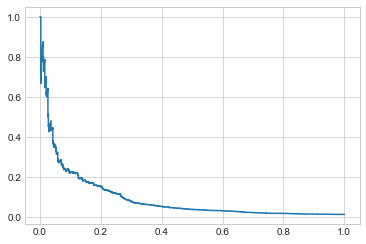

In [239]:
plt.plot(rec,pre)

In [237]:
sum(y_tr)/len(y_tr)

0.012832779872797883